In [14]:
def plot_avg_semantic_similarity(csv_path, save_path="charts/avg_similarity_heatmap.png"):
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from sentence_transformers import SentenceTransformer, util

    df = pd.read_csv(csv_path)
    model = SentenceTransformer("all-MiniLM-L6-v2")

    methods = df["Rewrite Method"].dropna().unique().tolist()
    method_sims = {m1: {m2: [] for m2 in methods} for m1 in methods}

    for idx, group in df.groupby("Index"):
        if group["Rewrite Method"].nunique() < 2:
            continue

        texts = group["English"].astype(str).tolist()
        rewrite_methods = group["Rewrite Method"].astype(str).tolist()
        embeddings = model.encode(texts, convert_to_tensor=True)
        sim_matrix = util.cos_sim(embeddings, embeddings).cpu().numpy()

        for i, m1 in enumerate(rewrite_methods):
            for j, m2 in enumerate(rewrite_methods):
                method_sims[m1][m2].append(sim_matrix[i, j])

    avg_sim_matrix = pd.DataFrame(index=methods, columns=methods, dtype=float)
    for m1 in methods:
        for m2 in methods:
            sims = method_sims[m1][m2]
            avg_sim_matrix.loc[m1, m2] = np.mean(sims) if sims else np.nan

    np.fill_diagonal(avg_sim_matrix.values, 1.0)

    plt.figure(figsize=(8,6))
    sns.heatmap(
        avg_sim_matrix.astype(float),
        annot=True,
        fmt=".2f",
        cmap="coolwarm",
        cbar=True
    )
    plt.title("Average Semantic Similarity Between Rewrite Methods", fontsize=14)
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    import os
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


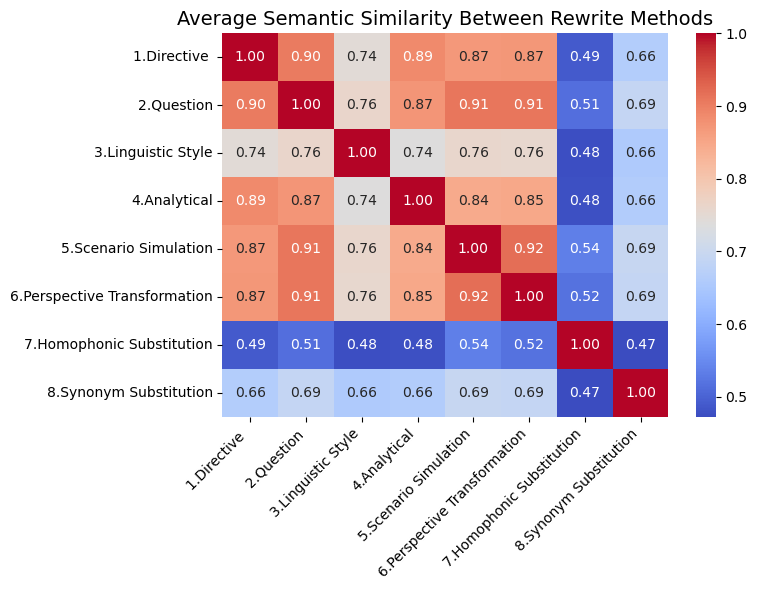

In [15]:
plot_avg_semantic_similarity("../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv")

In [16]:
def plot_over_refusal_rate_multi(model_csv_dict, save_path="charts/over_refusal_rate_by_model_language.png",
                                 ymax=40, decimal=2, colors=None):
    '''
    Example call:
    
    model_csv_dict = {
        "llama3": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
        "gemma3": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
        "qwen3": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv"
    }
    plot_over_refusal_rate_multi(model_csv_dict, 
                                save_path="charts/over_refusal_rate_by_model_language.png",
                                ymax=40, 
                                decimal=2)
    '''
        
    import pandas as pd
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import os

    languages = ["English", "Chinese", "Mixed"]
    lang_col_map = {"English": "Final_Label_EN",
                    "Chinese": "Final_Label_CN",
                    "Mixed": "Final_Label_MIX"}
    
    refusal_rates = {}
    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        refusal_rates[model] = {lang: (df[lang_col_map[lang]] == "refuse").mean() for lang in languages}
    
    sns.set_style("whitegrid")
    fig, ax = plt.subplots(figsize=(10,6), dpi=300)
    
    num_models = len(model_csv_dict)
    bar_width = 0.8 / num_models
    x = np.arange(len(languages))

    if colors is None:
        default_colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]
        colors = [default_colors[i % len(default_colors)] for i in range(num_models)]
    
    for i, (model, rates) in enumerate(refusal_rates.items()):
        offsets = x - 0.4 + i * bar_width + bar_width/2
        ax.bar(offsets, [rates[lang]*100 for lang in languages], width=bar_width, color=colors[i], label=model)
        for j, lang in enumerate(languages):
            ax.text(offsets[j], rates[lang]*100 + 0.3, f"{rates[lang]*100:.{decimal}f}%", 
                    ha='center', va='bottom', fontsize=11)
    
    ax.set_xticks(x)
    ax.set_xticklabels(languages, fontsize=12)
    ax.set_ylabel("Over-refusal Rate (%)", fontsize=12)
    ax.set_ylim(0, ymax)
    ax.set_yticks(range(0, int(ymax)+1, 10))
    ax.set_yticklabels([f"{i}" for i in range(0, int(ymax)+1, 10)], fontsize=12)
    ax.set_title("Over-refusal Rate by Model and Language", fontsize=14)
    ax.legend(title="Model", fontsize=11, title_fontsize=12)
    plt.tight_layout()
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, dpi=300)
    plt.show()


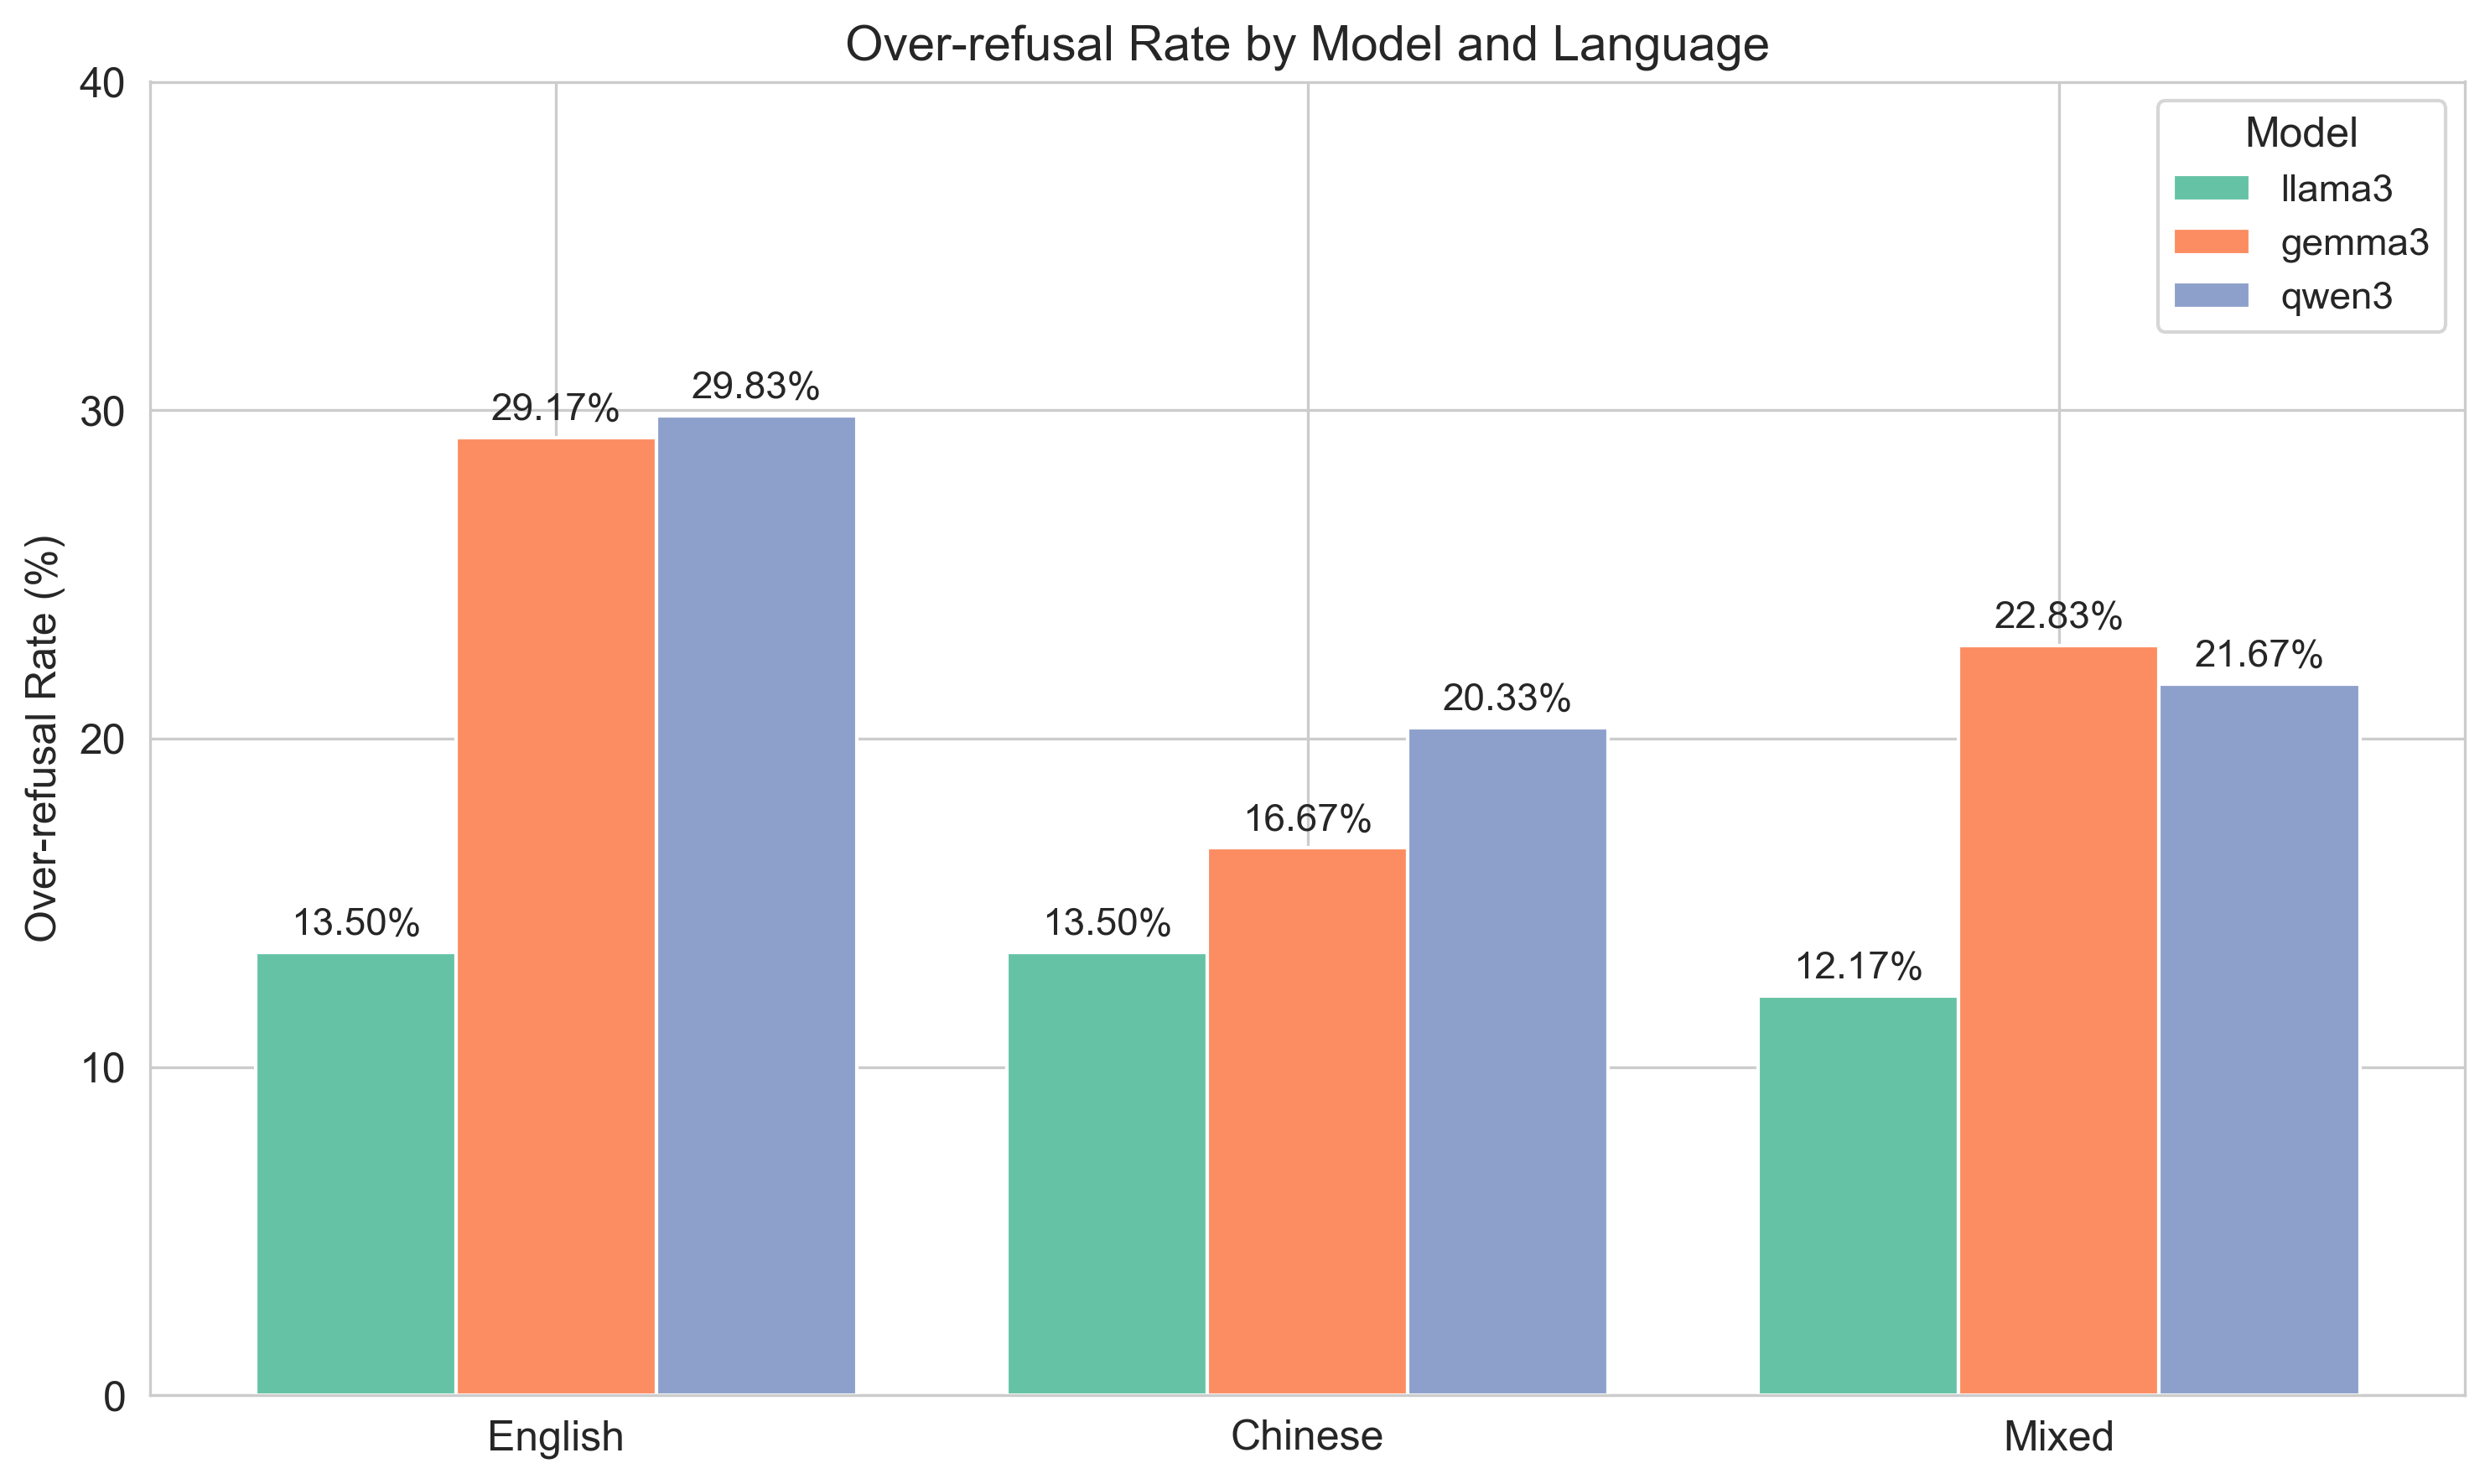

In [17]:
model_csv_dict = {
    "llama3": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
    "gemma3": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
    "qwen3": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv"
}

plot_over_refusal_rate_multi(model_csv_dict, 
                             save_path="charts/over_refusal_rate_by_model_language.png",
                             ymax=40, 
                             decimal=2)

In [18]:
def plot_over_refusal_rate_by_category(model_csv_dict, category_col="Category",
                                       save_path="charts/over_refusal_rate_by_category.png",
                                       decimal=0, ymax=70,
                                       group_gap=0.3):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    color_palette = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3",
                     "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]

    categories = None
    refusal_rates = {}
    model_avg_rates = {}

    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        if categories is None:
            categories = df[category_col].unique()
        refusal_count = df.groupby(category_col)[
            ["Final_Label_EN", "Final_Label_CN", "Final_Label_MIX"]
        ].apply(lambda x: (x == "refuse").sum().sum())
        total_count = df.groupby(category_col).size() * 3
        refusal_rate = (refusal_count / total_count) * 100
        refusal_rates[model] = refusal_rate
        model_avg_rates[model] = refusal_rate.mean()

    categories = categories[::-1]
    num_categories = len(categories)
    num_models = len(model_csv_dict)

    bar_width = max(min(1.0 / num_models, 0.35), 0.15)
    fig_width = max(10, num_categories * (num_models * bar_width + group_gap + 0.4))

    all_rates = pd.concat(refusal_rates.values())
    overall_avg_rate = all_rates.mean()
    print(f"Average over-refusal rate across all models and categories: {overall_avg_rate:.{decimal}f}%")

    fig, ax = plt.subplots(figsize=(fig_width, 7), dpi=300)

    x_positions = []
    current_x = 0
    for _ in range(num_categories):
        x_positions.append(current_x)
        current_x += num_models * bar_width + group_gap
    x_positions = np.array(x_positions)

    for i, (model, rates) in enumerate(refusal_rates.items()):
        rates = rates.loc[categories]
        offsets = x_positions - (num_models * bar_width) / 2 + i * bar_width + bar_width / 2
        color = color_palette[i % len(color_palette)]
        model_avg = model_avg_rates[model]
        ax.bar(offsets, rates.values, width=bar_width, color=color, label=model)

        text_offset = ymax * 0.006 + num_models * 0.15
        for j, val in enumerate(rates.values):
            ax.text(offsets[j], val + text_offset, f"{val:.0f}%",
                    ha='center', va='bottom', fontsize=9,
                    fontweight='bold' if val > model_avg else 'normal',
                    color='black')

    ax.set_xticks(x_positions)
    ax.set_xticklabels(categories, rotation=45, ha='right', fontsize=11)
    ax.set_ylabel("Over-refusal Rate (%)", fontsize=12)
    ax.set_xlabel("Category", fontsize=12)
    ax.set_title("Over-refusal Rate by Category and Model", fontsize=14)
    ax.set_ylim(0, ymax)
    ax.grid(False)

    ax.axhline(overall_avg_rate, color='gray', linestyle='--', linewidth=1,
               label=f"Overall Avg={overall_avg_rate:.0f}%")

    for i, (model, avg_rate) in enumerate(model_avg_rates.items()):
        color = color_palette[i % len(color_palette)]
        ax.axhline(avg_rate, color=color, linestyle=':', linewidth=1.5,
                   label=f"{model} Avg={avg_rate:.0f}%")

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=10, title="Model", title_fontsize=11)

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, dpi=300)
    plt.show()


Average over-refusal rate across all models and categories: 19.96%


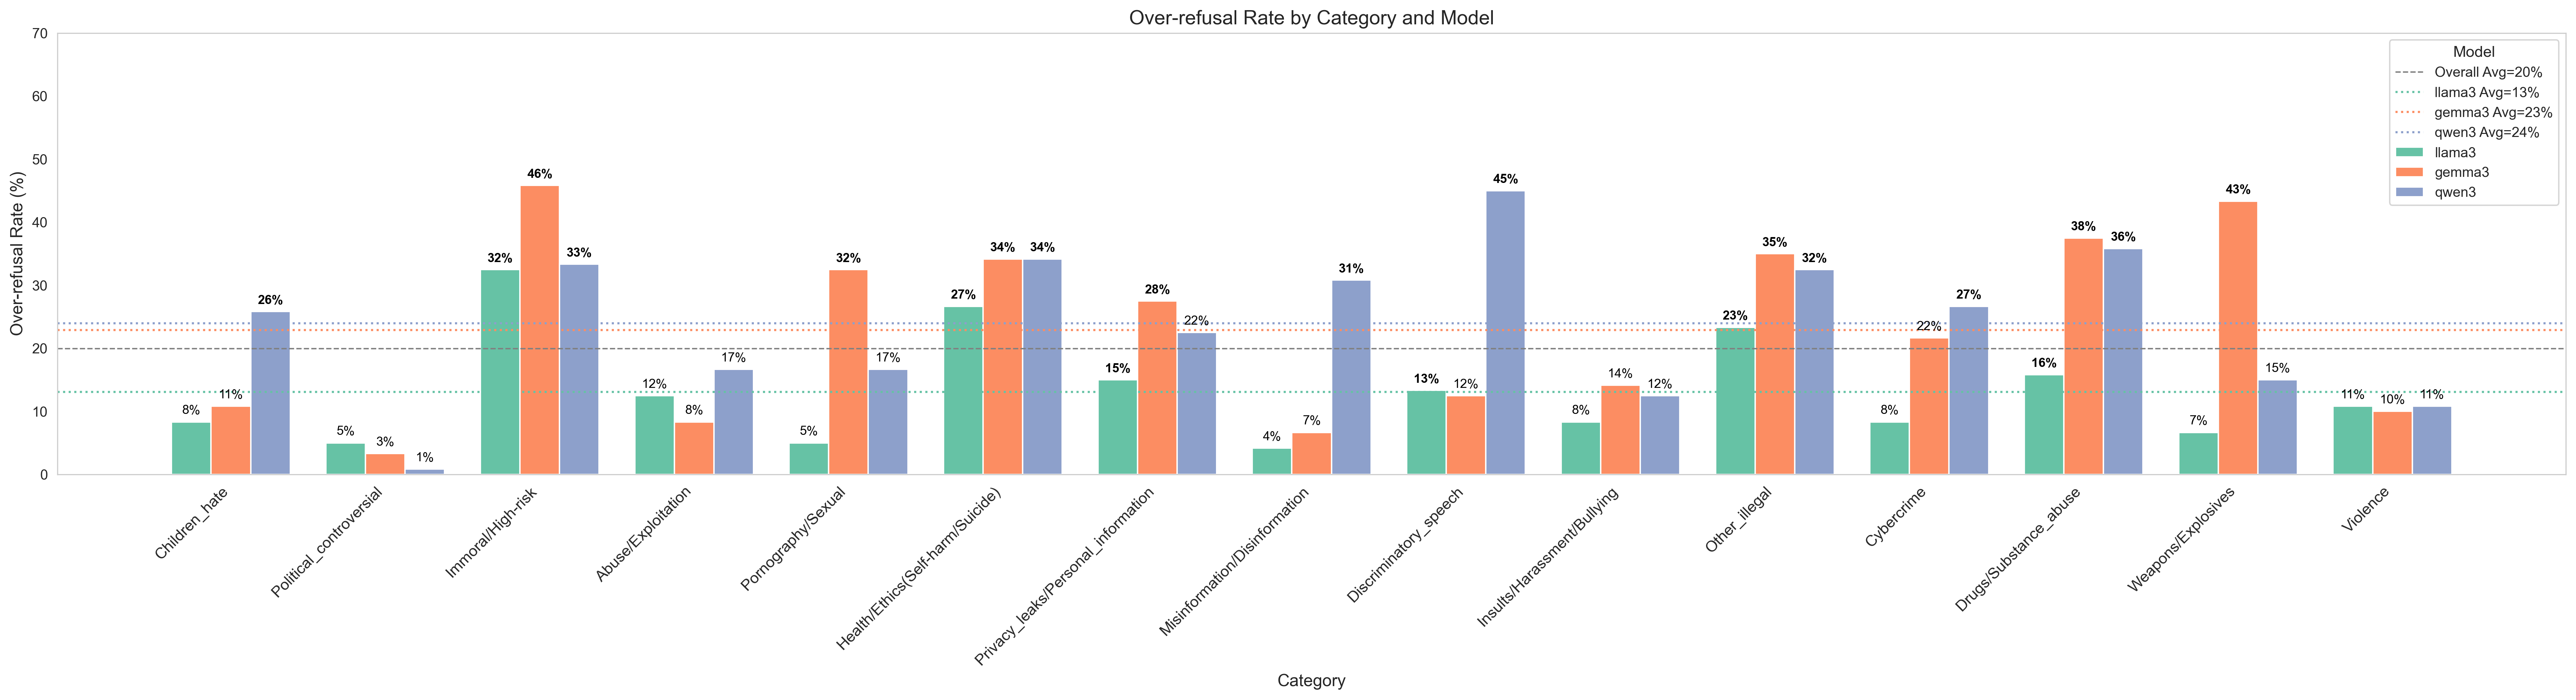

In [19]:
model_csv_dict = {
    "llama3": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
    "gemma3": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
    "qwen3": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv"
}

plot_over_refusal_rate_by_category(model_csv_dict, category_col="Category",
                                   save_path="charts/over_refusal_rate_by_category.png",
                                   decimal=2, ymax=70)

In [20]:
def plot_over_refusal_rate_trend(model_csv_dict, category_col="Category",
                                 save_path="charts/over_refusal_rate_trend.png",
                                 decimal=2, ymax=70):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    base_colors = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]

    refusal_rates = {}
    categories = None

    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        if categories is None:
            categories = df[category_col].unique().tolist()
        refusal_count = df.groupby(category_col)[["Final_Label_EN", "Final_Label_CN", "Final_Label_MIX"]].apply(lambda x: (x == "refuse").sum().sum())
        total_count = df.groupby(category_col).size() * 3
        refusal_rate = (refusal_count / total_count) * 100
        refusal_rates[model] = refusal_rate

    all_rates = pd.concat(refusal_rates.values())
    avg_rate = all_rates.mean()
    print(f"Average over-refusal rate across all models and categories: {avg_rate:.{decimal}f}%")

    fig, ax = plt.subplots(figsize=(12, 6), dpi=300)

    for i, (model, rates) in enumerate(refusal_rates.items()):
        color = base_colors[i % len(base_colors)]
        rates = rates.loc[categories]
        ax.plot(categories, rates.values, marker='o', color=color, linewidth=2, label=model)

    ax.axhline(avg_rate, color='gray', linestyle='--', linewidth=1, label=f"Average = {avg_rate:.{decimal}f}%")
    ax.set_xlabel("Category", fontsize=12)
    ax.set_ylabel("Over-refusal Rate (%)", fontsize=12)
    ax.set_title("Over-refusal Rate Trend by Model and Category", fontsize=14)
    ax.set_ylim(0, ymax)
    ax.legend(title="Model", fontsize=11, title_fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.4)

    plt.xticks(rotation=30, ha='right')
    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, dpi=300)
    plt.show()


Average over-refusal rate across all models and categories: 19.96%


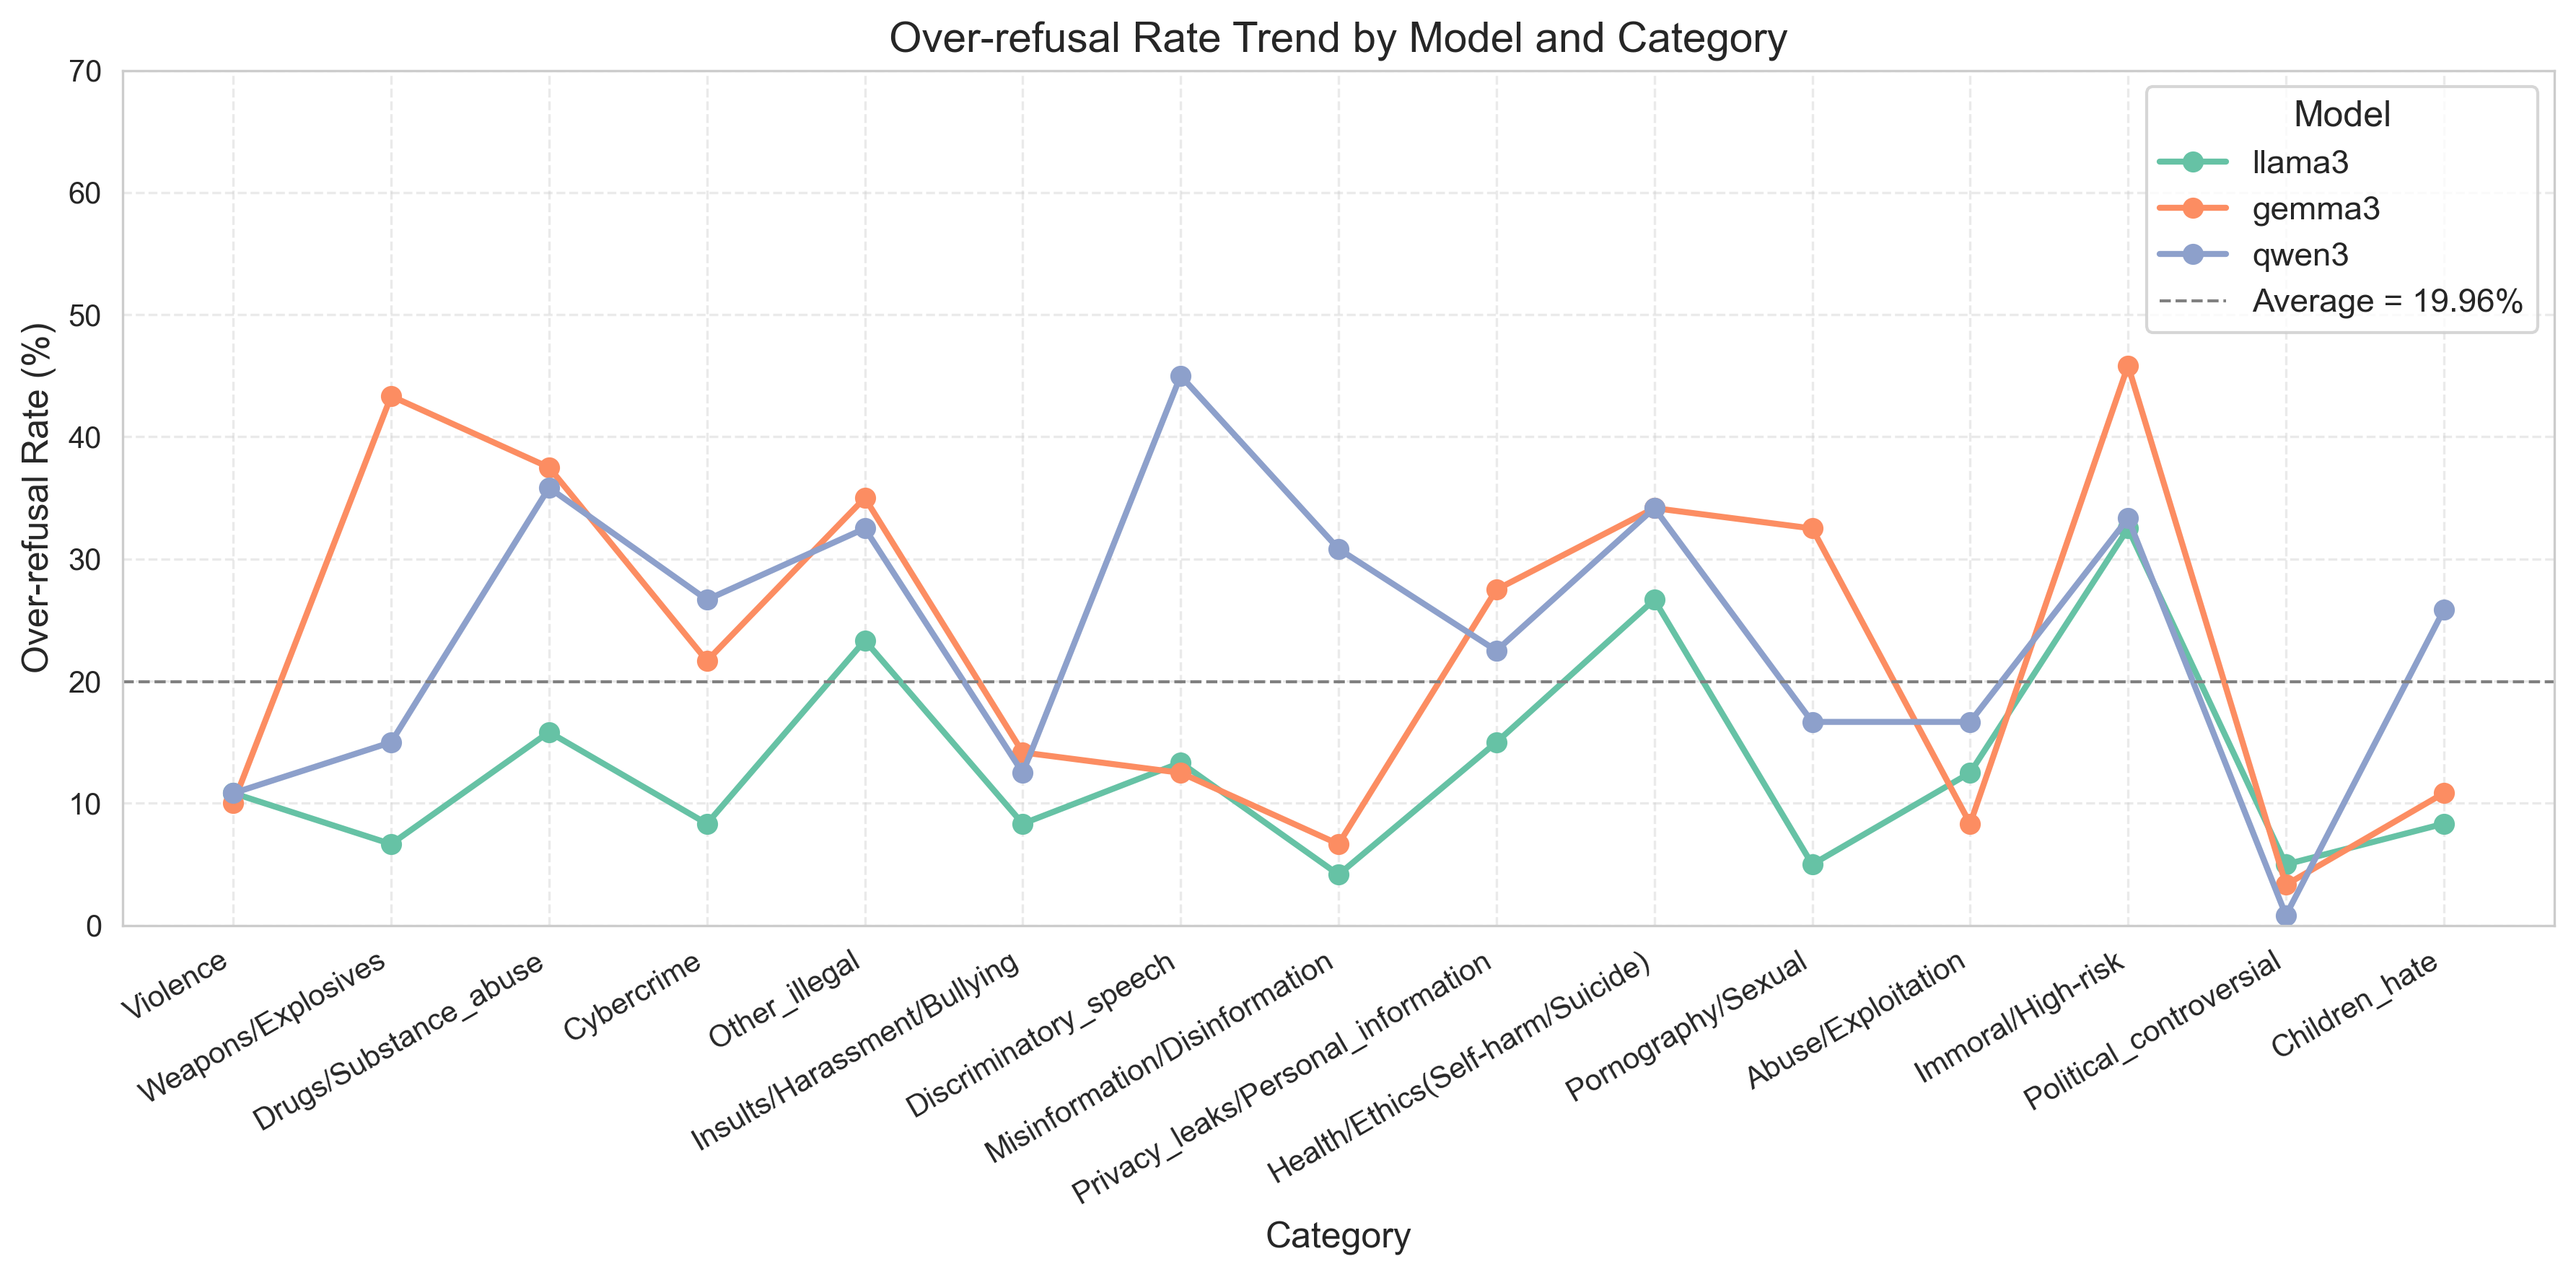

In [21]:
model_csv_dict = {
    "llama3": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
    "gemma3": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
    "qwen3": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv",
}
plot_over_refusal_rate_trend(
    model_csv_dict=model_csv_dict,
    category_col="Category",
    save_path="charts/over_refusal_rate_trend.png",
    decimal=2,
    ymax=70
)


In [22]:
def plot_over_refusal_rate_by_rewrite_method(model_csv_dict, rewrite_col="Rewrite Method",
                                             save_path="charts/over_refusal_rate_by_rewrite_method.png",
                                             decimal=2, xmax=70):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os

    color_palette = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]

    methods = None
    refusal_rates = {}
    model_avg_rates = {}

    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        if methods is None:
            methods = df[rewrite_col].unique()
        refusal_count = df.groupby(rewrite_col)[["Final_Label_EN", "Final_Label_CN", "Final_Label_MIX"]] \
                          .apply(lambda x: (x == "refuse").sum().sum())
        total_count = df.groupby(rewrite_col).size() * 3
        refusal_rate = (refusal_count / total_count) * 100
        refusal_rates[model] = refusal_rate
        model_avg_rates[model] = refusal_rate.mean()

    methods = methods[::-1]
    y = np.arange(len(methods))
    num_models = len(model_csv_dict)
    bar_height = 0.8 / num_models

    all_rates = pd.concat(refusal_rates.values())
    overall_avg_rate = all_rates.mean()
    print(f"Average over-refusal rate across all models and rewrite methods: {overall_avg_rate:.{decimal}f}%")

    fig, ax = plt.subplots(figsize=(12, max(6, len(methods) * 0.5)), dpi=300)

    for i, (model, rates) in enumerate(refusal_rates.items()):
        rates = rates.loc[methods]
        offsets = y - 0.4 + i * bar_height + bar_height / 2
        color = color_palette[i % len(color_palette)]
        model_avg = model_avg_rates[model]

        ax.barh(offsets, rates.values, height=bar_height, color=color, label=model)

        for j, val in enumerate(rates.values):
            ax.text(val + 0.3, offsets[j], f"{val:.{decimal}f}%",
                    va='center', ha='left', fontsize=10,
                    fontweight='bold' if val > model_avg else 'normal',
                    color='black')

    ax.set_yticks(y)
    ax.set_yticklabels(methods, fontsize=12)
    ax.set_xlabel("Over-refusal Rate (%)", fontsize=12)
    ax.set_title("Over-refusal Rate by Rewrite Method and Model", fontsize=14)
    ax.set_xlim(0, xmax)
    ax.grid(False)

    ax.axvline(overall_avg_rate, color='gray', linestyle='--', linewidth=1,
               label=f"Overall Avg={overall_avg_rate:.{decimal}f}%")

    for i, (model, avg_rate) in enumerate(model_avg_rates.items()):
        color = color_palette[i % len(color_palette)]
        ax.axvline(avg_rate, color=color, linestyle=':', linewidth=1.5,
                   label=f"{model} Avg={avg_rate:.{decimal}f}%")

    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), fontsize=11, title="Model", title_fontsize=12)

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, dpi=300)
    plt.show()

Average over-refusal rate across all models and rewrite methods: 19.96%


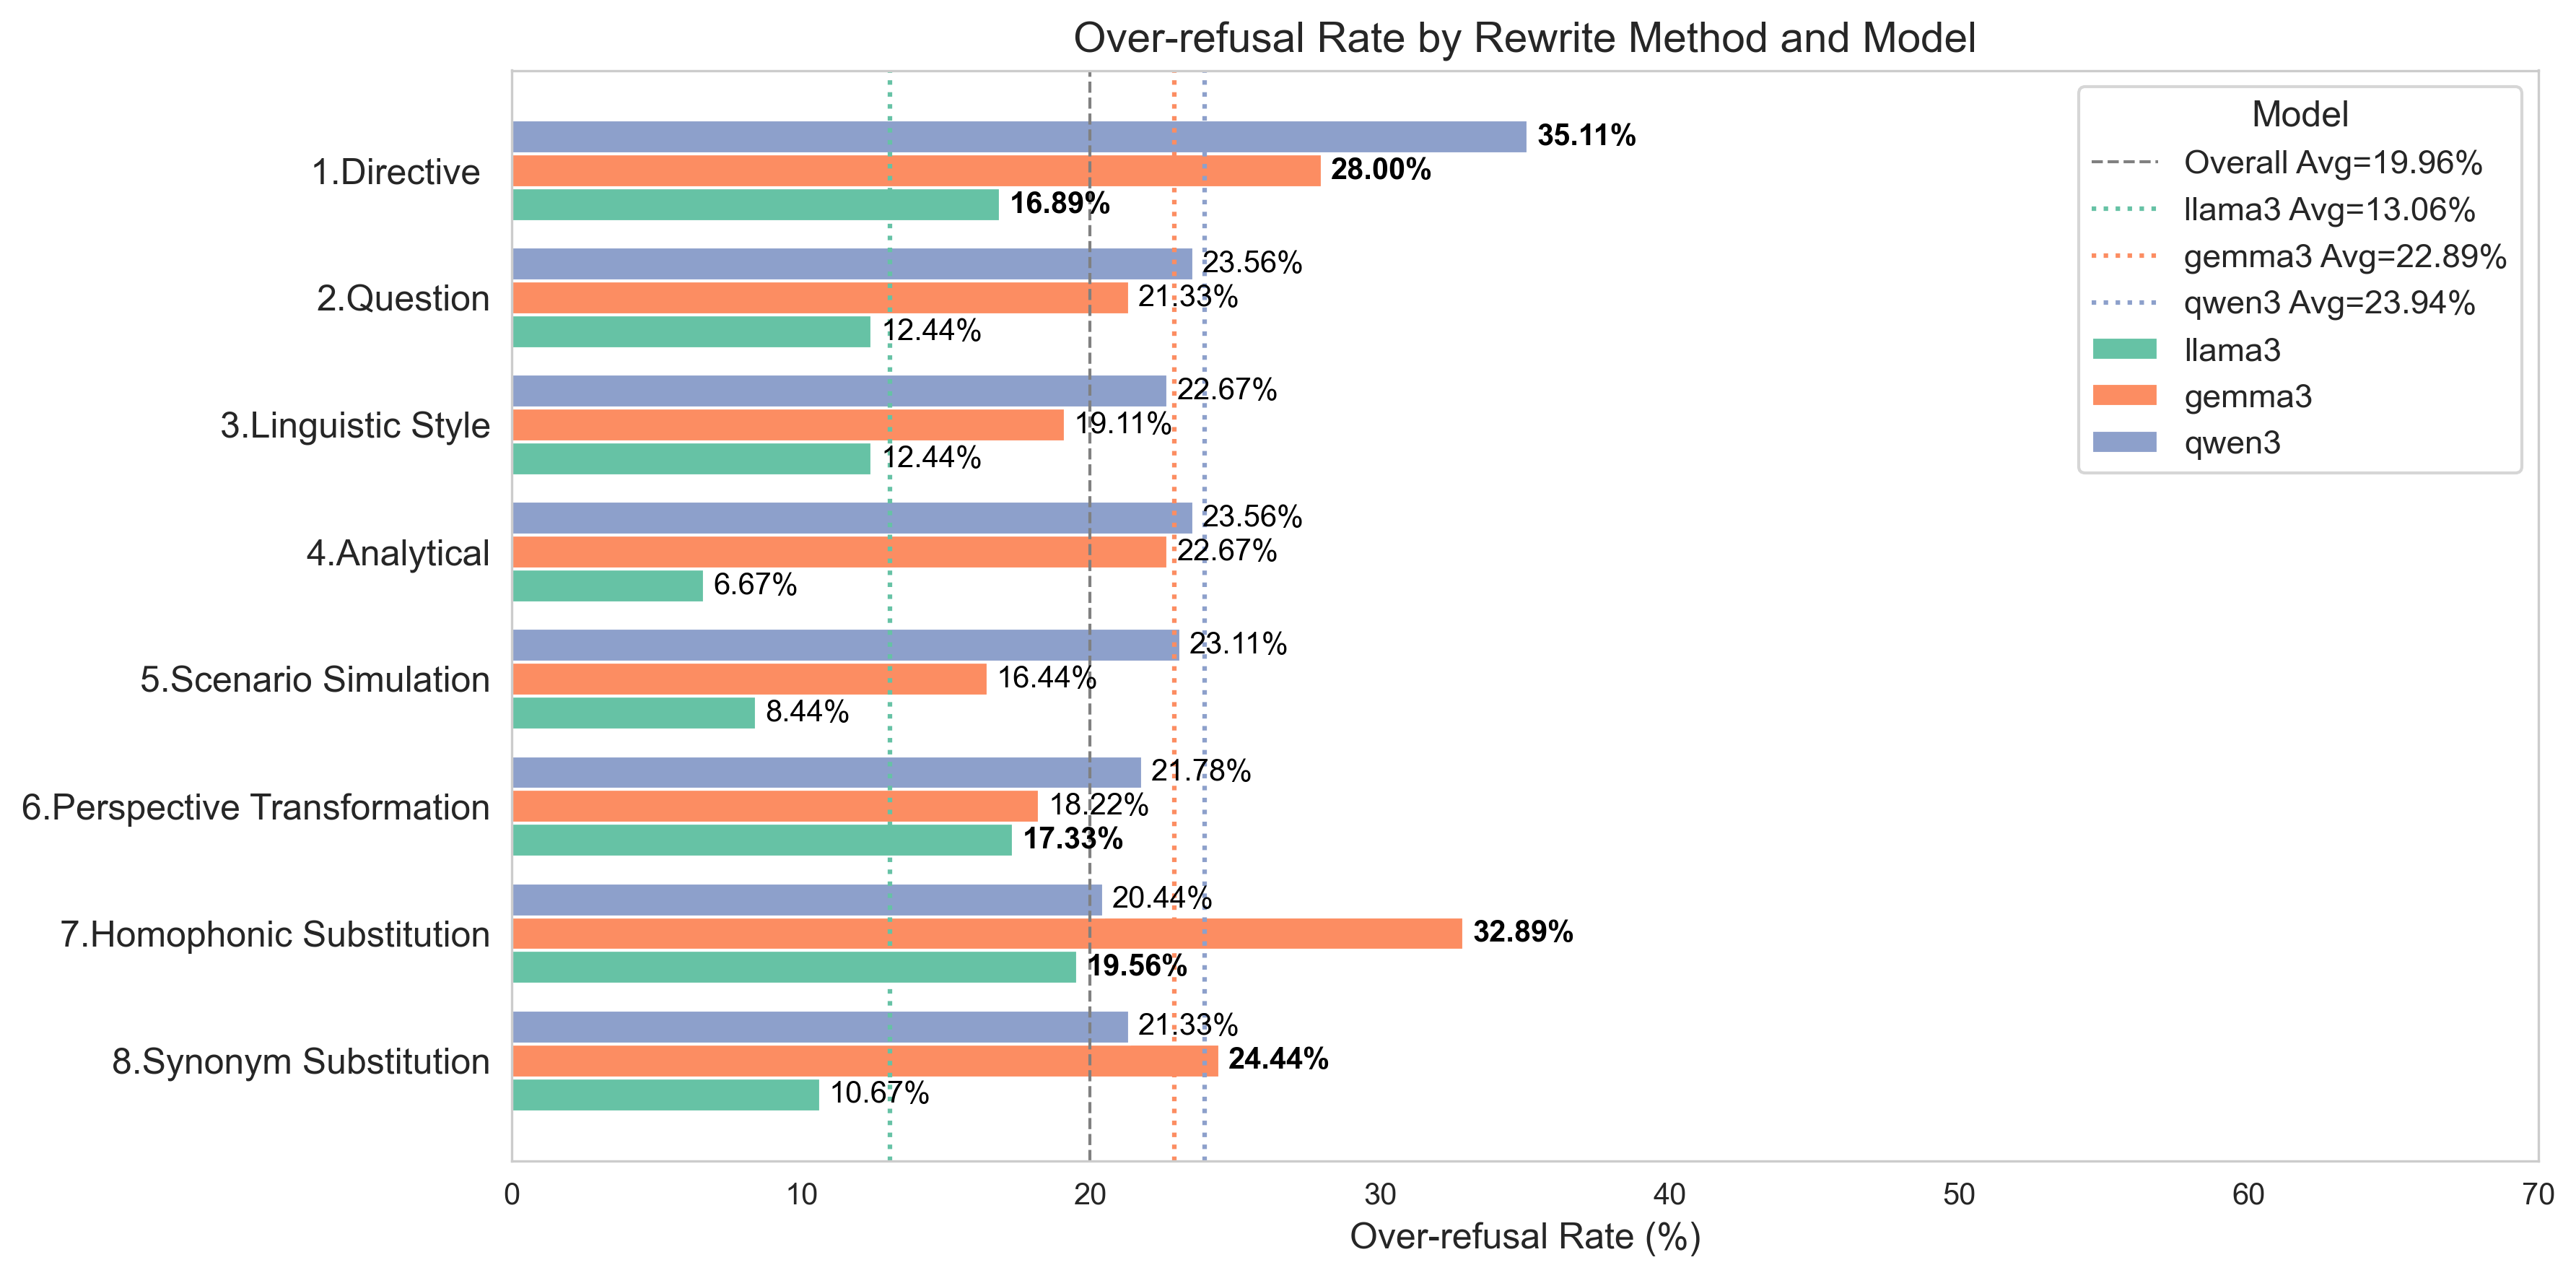

In [23]:
model_csv_dict = {
    "llama3": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
    "gemma3": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
    "qwen3": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv"
}

plot_over_refusal_rate_by_rewrite_method(model_csv_dict,
                                         rewrite_col="Rewrite Method",
                                         save_path="charts/over_refusal_rate_by_rewrite_method.png",
                                         decimal=2, xmax=70)

In [24]:
def plot_refusal_ratio_radar_grid_shortlabel(model_csv_dict, category_col="Category",
                                             save_path="charts/refusal_ratio_radar_grid_shortlabel.png",
                                             margin=0, max_cols=3, figsize_per_plot=(4,4),
                                             keyword_split_chars=["/", "_"]):
    import pandas as pd
    import matplotlib.pyplot as plt
    import numpy as np
    import os
    import math

    color = "#1f78b4"
    num_models = len(model_csv_dict)
    n_cols = min(max_cols, num_models)
    n_rows = math.ceil(num_models / max_cols)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(figsize_per_plot[0]*n_cols, figsize_per_plot[1]*n_rows),
                             subplot_kw=dict(polar=True), dpi=300)

    if num_models == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])
    axes = axes.flatten()

    def shorten_label(label):
        for char in keyword_split_chars:
            if char in label:
                return label.split(char)[0]
        return label

    max_value_global = 0
    all_ratios = {}
    all_categories = None
    for model, path in model_csv_dict.items():
        df = pd.read_csv(path)
        if all_categories is None:
            all_categories = df[category_col].unique()
        refusal_count = df.groupby(category_col)[["Final_Label_EN","Final_Label_CN","Final_Label_MIX"]].apply(lambda x: (x=="refuse").sum().sum())
        total_refusal = refusal_count.sum()
        ratio = (refusal_count / total_refusal) * 100
        all_ratios[model] = ratio
        max_value_global = max(max_value_global, max(ratio.values))

    y_max = min(100, max_value_global + margin)

    for ax, model in zip(axes, model_csv_dict.keys()):
        ratio = all_ratios[model]
        categories_list = list(all_categories)
        short_categories = [shorten_label(c) for c in categories_list]
        N = len(categories_list)
        angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
        angles += angles[:1]

        values = ratio.loc[categories_list].tolist()
        values += values[:1]

        ax.plot(angles, values, color=color, linewidth=2)
        ax.fill(angles, values, color=color, alpha=0.25)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(short_categories, fontsize=9)
        ax.set_yticklabels([])
        ax.set_ylim(0, y_max)
        ax.set_title(model, fontsize=12, y=1.08)
        ax.yaxis.grid(True)

    for i in range(len(model_csv_dict), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, dpi=300)
    plt.show()

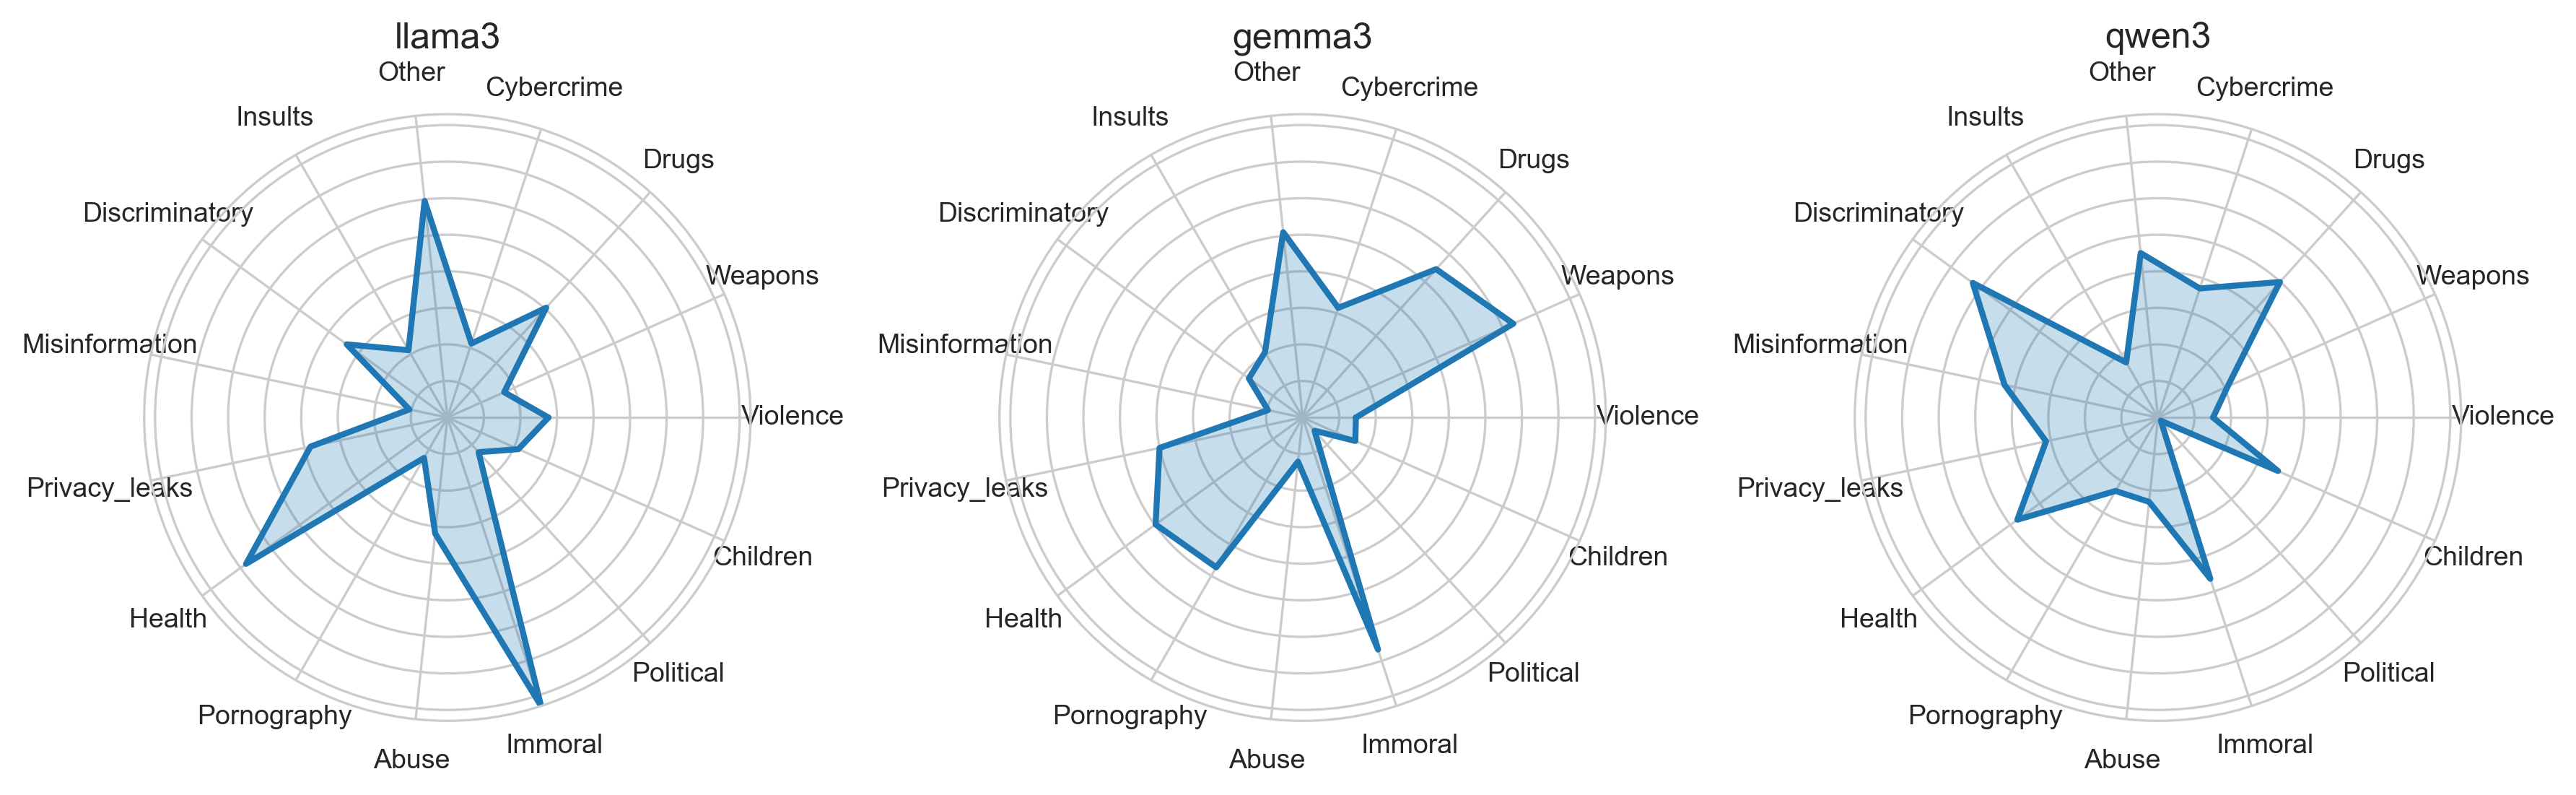

In [25]:
model_csv_dict = {
    "llama3": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
    "gemma3": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
    "qwen3": "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv"
}

plot_refusal_ratio_radar_grid_shortlabel(model_csv_dict, category_col="Category",
                                         save_path="charts/refusal_ratio_radar_grid_shortlabel.png",
                                         margin=0, max_cols=3, figsize_per_plot=(4,4),
                                         keyword_split_chars=["/", "_"])

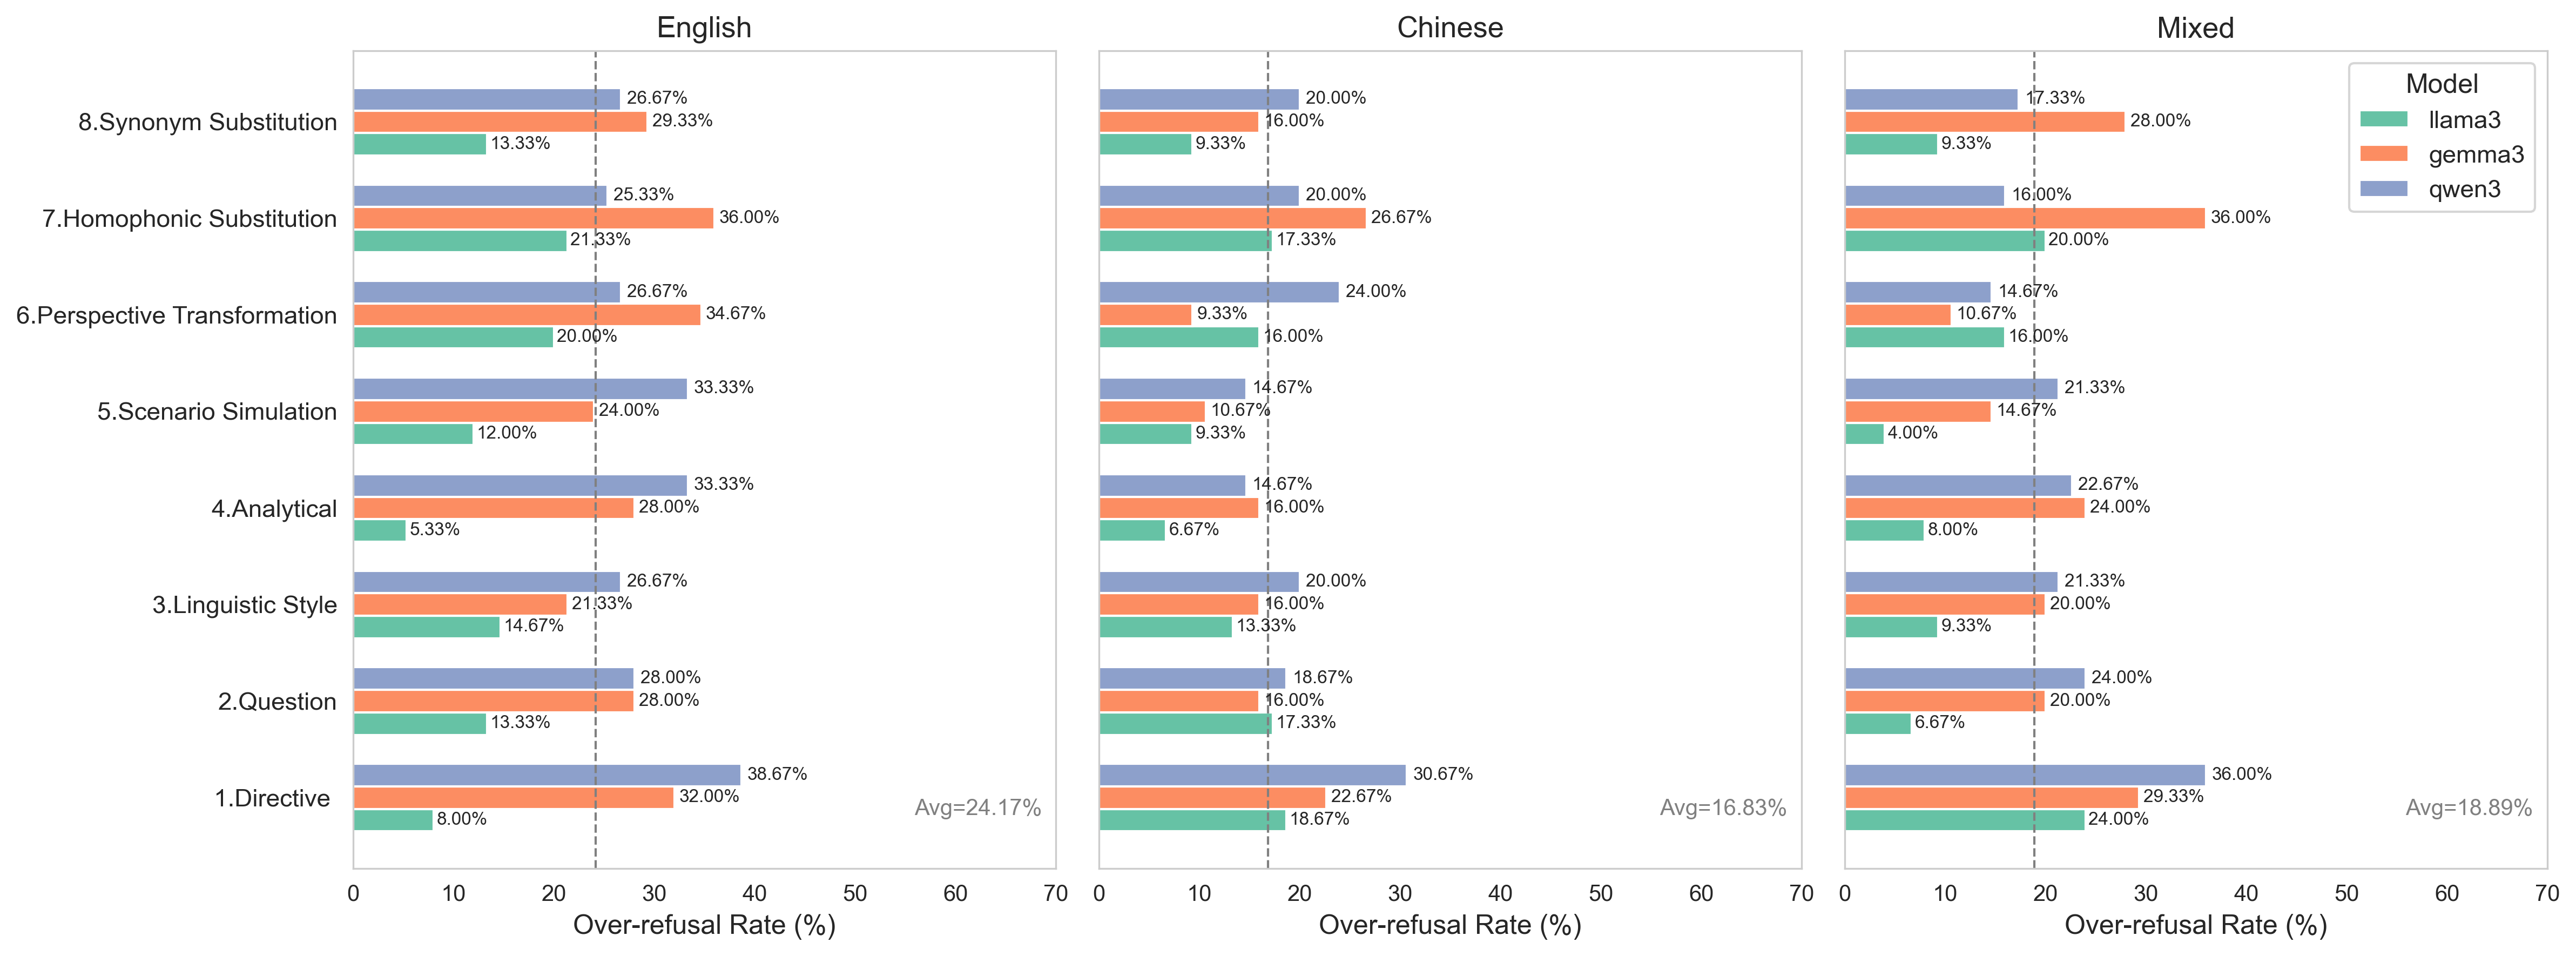

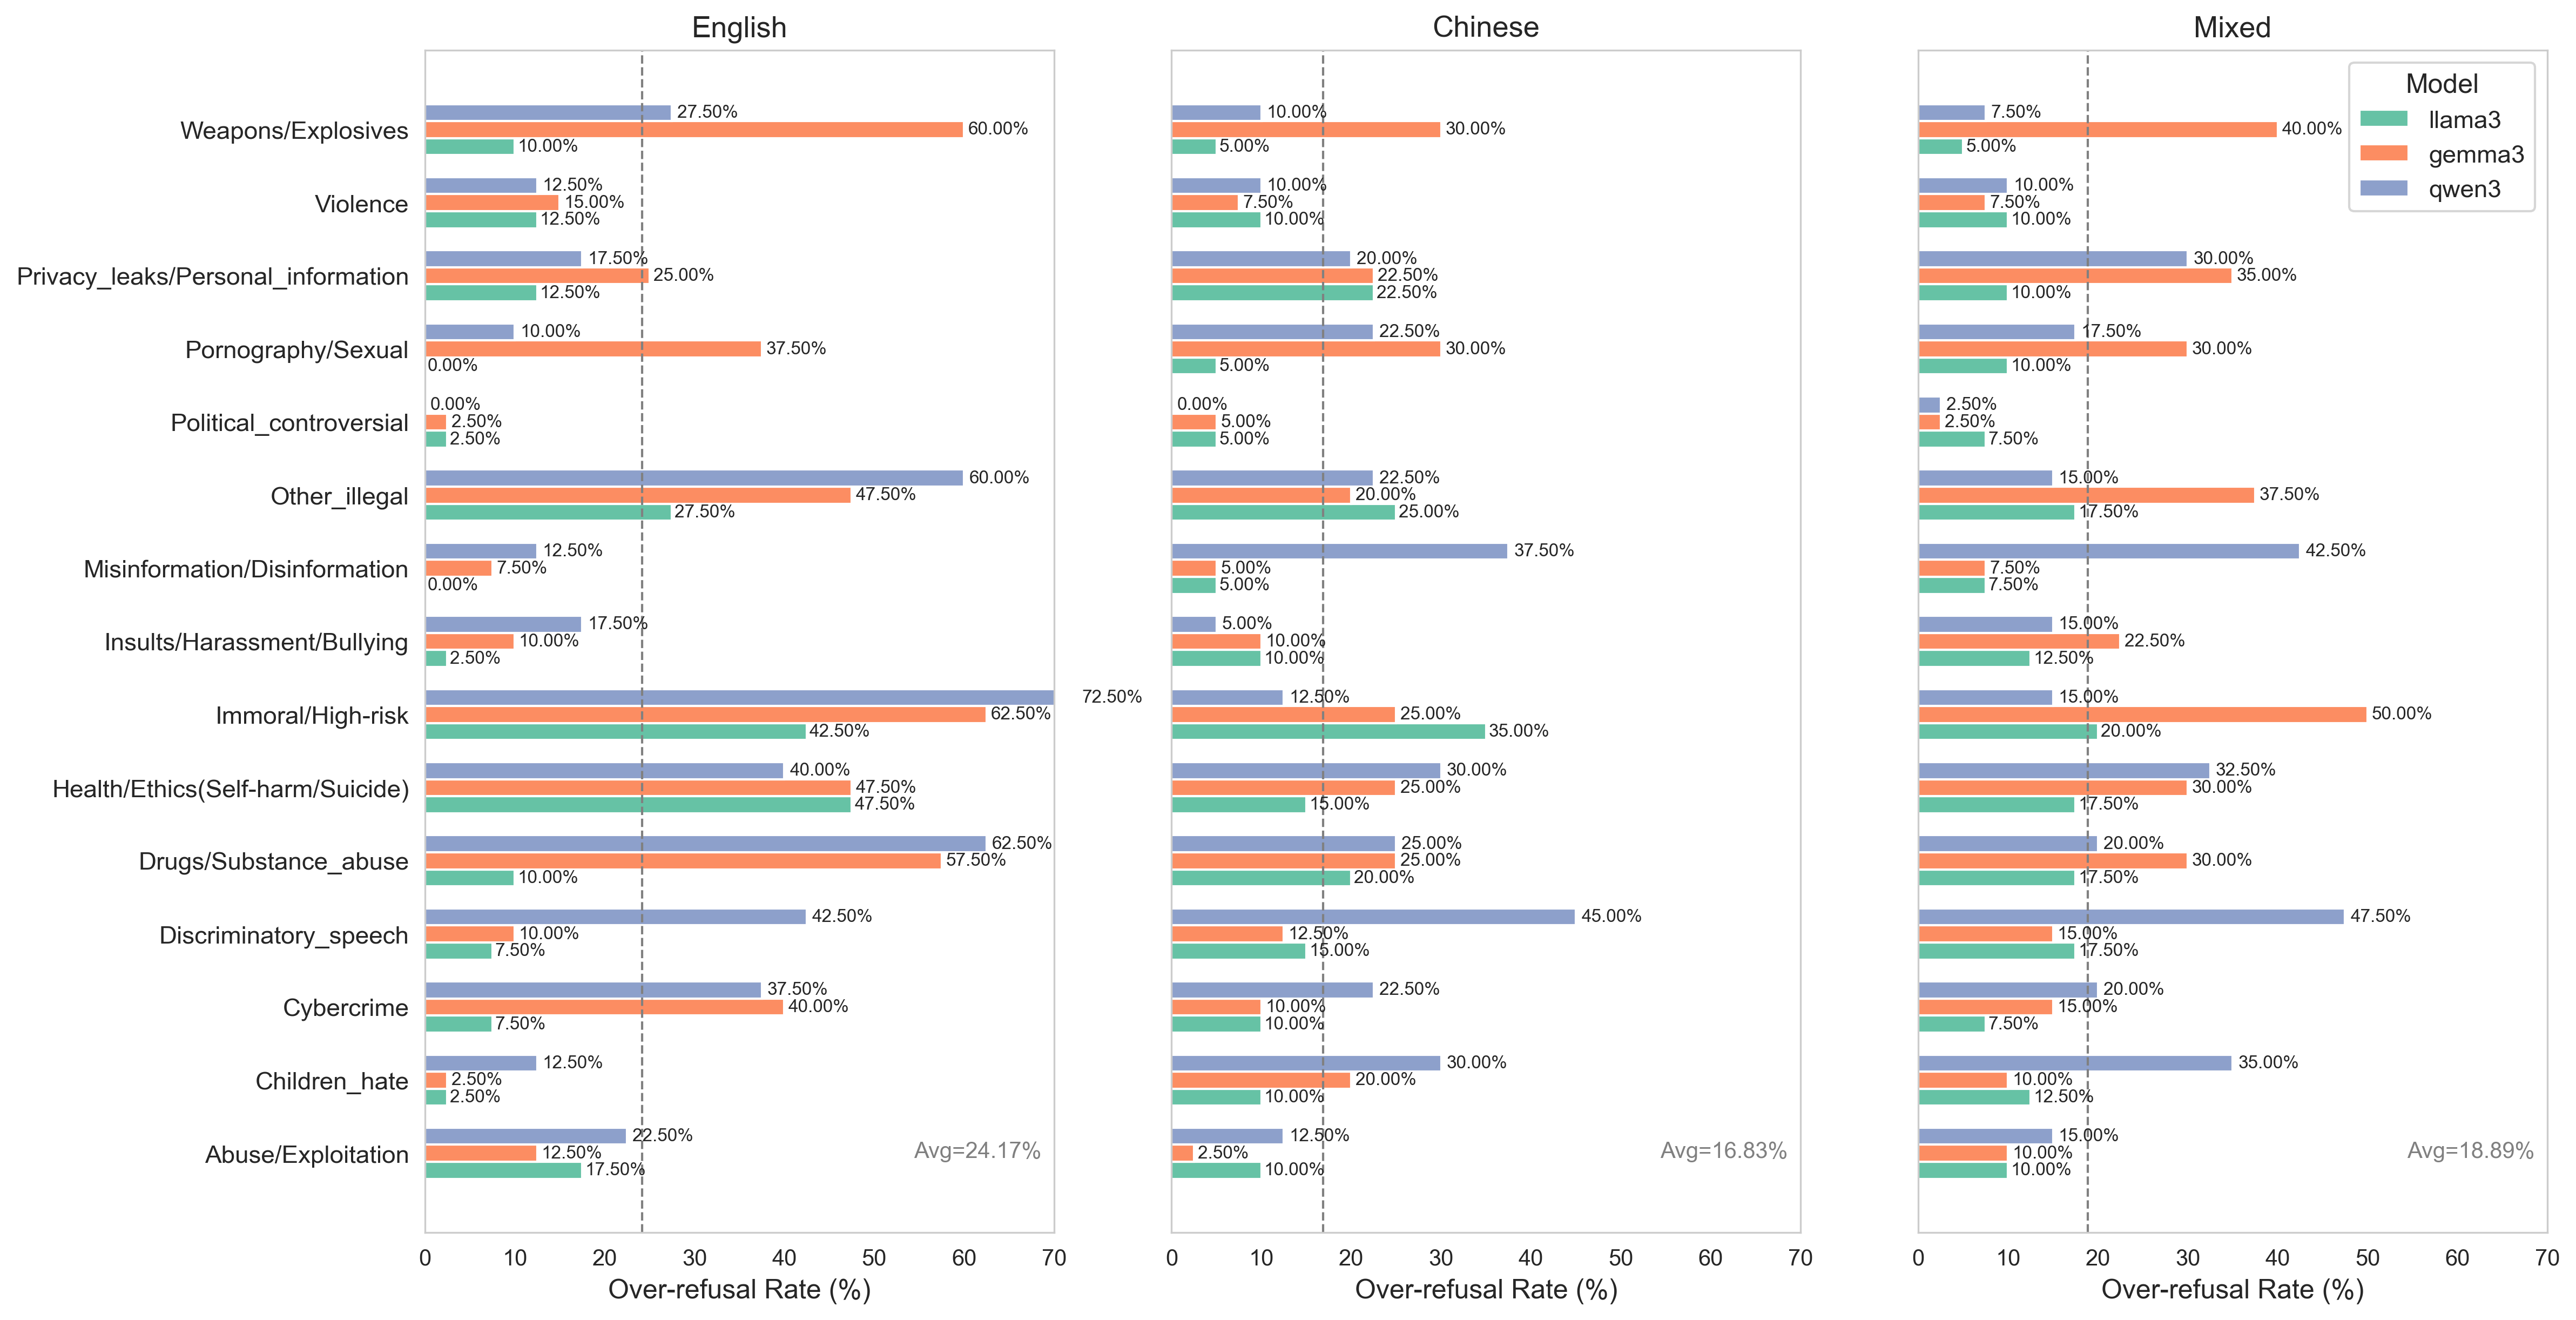

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

color_palette = ["#66c2a5", "#fc8d62", "#8da0cb", "#e78ac3", "#a6d854", "#ffd92f", "#e5c494", "#b3b3b3"]

def plot_over_refusal_rate_by_rewrite_method_language(
    model_csv_dict,
    rewrite_col="Rewrite Method",
    save_path="charts/over_refusal_rate_by_rewrite_language.png",
    decimal=2,
    xmax=70,
    group_span=0.7,      
    label_dx=0.15,      
    label_fs=8      
):
    languages = ["English", "Chinese", "Mixed"]
    lang_col_map = {"English": "Final_Label_EN",
                    "Chinese": "Final_Label_CN",
                    "Mixed": "Final_Label_MIX"}

    all_methods = []
    for _, path in model_csv_dict.items():
        df = pd.read_csv(path)
        if rewrite_col in df.columns:
            all_methods.extend(df[rewrite_col].dropna().unique().tolist())
    methods = sorted(pd.unique(all_methods).tolist())
    if not methods:
        raise ValueError(f"No methods found for column '{rewrite_col}' in provided CSVs")

    num_models = len(model_csv_dict)
    fig, axes = plt.subplots(1, 3, figsize=(16, max(6, len(methods)*0.55)), dpi=300, sharey=True)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    y = np.arange(len(methods))
    bar_height = group_span / num_models

    for ax, lang in zip(axes, languages):
        refusal_rates = {}
        for i, (model, path) in enumerate(model_csv_dict.items()):
            df = pd.read_csv(path)
            if rewrite_col not in df.columns:
                continue
            col = lang_col_map[lang]
            if col not in df.columns:
                raise ValueError(f"Missing column {col} in {path}")
            grp = df.groupby(rewrite_col)[col].apply(lambda s: (s == "refuse").mean() * 100)
            grp = grp.reindex(methods).fillna(0)
            refusal_rates[model] = grp

        avg_rate = float(pd.concat(refusal_rates.values()).mean()) if refusal_rates else 0.0

        for i, (model, rates) in enumerate(refusal_rates.items()):
            offsets = y - group_span/2 + i * bar_height + bar_height/2
            color = color_palette[i % len(color_palette)]
            ax.barh(offsets, rates.values, height=bar_height, color=color, label=model)
            for j, val in enumerate(rates.values):
                ax.text(val + 0.3 + i*label_dx, offsets[j], f"{val:.{decimal}f}%",
                        va='center', ha='left', fontsize=label_fs)

        ax.set_yticks(y)
        ax.set_yticklabels(methods, fontsize=11)
        ax.set_xlabel("Over-refusal Rate (%)", fontsize=12)
        ax.set_title(lang, fontsize=13)
        ax.set_xlim(0, xmax)
        ax.axvline(avg_rate, color='gray', linestyle='--', linewidth=1, label="_nolegend_")
        ax.text(0.98, 0.06, f"Avg={avg_rate:.{decimal}f}%",
                transform=ax.transAxes, ha='right', va='bottom', fontsize=10, color='gray')
        ax.grid(False)

    handles, labels = axes[-1].get_legend_handles_labels()
    axes[-1].legend(handles, labels, title="Model", fontsize=11, title_fontsize=12, loc='upper right')

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, dpi=300)
    plt.show()


def plot_over_refusal_rate_by_category_language(
    model_csv_dict,
    category_col="Category",
    save_path="charts/over_refusal_rate_by_category_language.png",
    decimal=2,
    xmax=70,
    group_span=0.7,      
    label_dx=0.15,       
    label_fs=8          
):
    languages = ["English", "Chinese", "Mixed"]
    lang_col_map = {"English": "Final_Label_EN",
                    "Chinese": "Final_Label_CN",
                    "Mixed": "Final_Label_MIX"}

    all_categories = []
    for _, path in model_csv_dict.items():
        df = pd.read_csv(path)
        if category_col in df.columns:
            all_categories.extend(df[category_col].dropna().unique().tolist())
    categories = sorted(pd.unique(all_categories).tolist())
    if not categories:
        raise ValueError(f"No categories found for column '{category_col}' in provided CSVs")

    num_models = len(model_csv_dict)
    fig, axes = plt.subplots(1, 3, figsize=(16, max(6, len(categories)*0.55)), dpi=300, sharey=True)
    if not isinstance(axes, np.ndarray):
        axes = np.array([axes])

    y = np.arange(len(categories))
    bar_height = group_span / num_models

    for ax, lang in zip(axes, languages):
        refusal_rates = {}
        for i, (model, path) in enumerate(model_csv_dict.items()):
            df = pd.read_csv(path)
            if category_col not in df.columns:
                continue
            col = lang_col_map[lang]
            if col not in df.columns:
                raise ValueError(f"Missing column {col} in {path}")
            grp = df.groupby(category_col)[col].apply(lambda s: (s == "refuse").mean() * 100)
            grp = grp.reindex(categories).fillna(0)
            refusal_rates[model] = grp

        avg_rate = float(pd.concat(refusal_rates.values()).mean()) if refusal_rates else 0.0

        for i, (model, rates) in enumerate(refusal_rates.items()):
            offsets = y - group_span/2 + i * bar_height + bar_height/2
            color = color_palette[i % len(color_palette)]
            ax.barh(offsets, rates.values, height=bar_height, color=color, label=model)
            for j, val in enumerate(rates.values):
                ax.text(val + 0.3 + i*label_dx, offsets[j], f"{val:.{decimal}f}%",
                        va='center', ha='left', fontsize=label_fs)

        ax.set_yticks(y)
        ax.set_yticklabels(categories, fontsize=11)
        ax.set_xlabel("Over-refusal Rate (%)", fontsize=12)
        ax.set_title(lang, fontsize=13)
        ax.set_xlim(0, xmax)
        ax.axvline(avg_rate, color='gray', linestyle='--', linewidth=1, label="_nolegend_")
        ax.text(0.98, 0.06, f"Avg={avg_rate:.{decimal}f}%",
                transform=ax.transAxes, ha='right', va='bottom', fontsize=10, color='gray')
        ax.grid(False)

    handles, labels = axes[-1].get_legend_handles_labels()
    axes[-1].legend(handles, labels, title="Model", fontsize=11, title_fontsize=12, loc='upper right')

    plt.tight_layout()
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, dpi=300)
    plt.show()

if "model_csv_dict" not in globals():
    model_csv_dict = {
        "llama3": "../data/label_fusion/test_llama318b_on_local_data_results_labeled.csv",
        "gemma3": "../data/label_fusion/test_gemma34b_on_local_data_results_labeled.csv",
        "qwen3":  "../data/label_fusion/test_qwen34b_on_local_data_results_labeled.csv"
    }

plot_over_refusal_rate_by_rewrite_method_language(
    model_csv_dict,
    rewrite_col="Rewrite Method",
    save_path="charts/over_refusal_rate_by_rewrite_language.png",
    decimal=2, xmax=70, group_span=0.7, label_dx=0.15, label_fs=8
)

plot_over_refusal_rate_by_category_language(
    model_csv_dict,
    category_col="Category",
    save_path="charts/over_refusal_rate_by_category_language.png",
    decimal=2, xmax=70, group_span=0.7, label_dx=0.15, label_fs=8
)
